### Steps in the exercise
1. Import the CSV
2. Use data dictionary to understand the current data
3. Perform EDA on the given data
4. Split the data in train and validation data. Save them to a csv.
5. Create a new notebook. Moving forward all operations on the train data
<br><br>
6. Impute missing values - Replace with zero/Average/MICE
7. Check for outliers and treat them if needed
8. Use SMOTE to solve the class imbalance problem
<br><br>
9. Standarize the values - Using Standard Scaler, Robust Scaler(For missing values)
10. Build a simple Logistic Regression model first, use RFE, VIF and PValue. Calculate accuracy, precision.
<br><br>
11. Use corelation matrix to see what percentage of columns are corelated. If high corelation is there we will build a PCA model.
12. Use TSNE for dimensionality reduction
13. Choose the components for PCA
13. Using the components of the PCA and build a Logistic Regression model
14. Calculate accuracy, precision.
<br><br>
15. Use Random Forest classifier
16. Apply PCA on top
17. Use extreme gradient boosting for better performance
18. Build a scatter plot and check for relationship between the columns.
19. Try with a SVM model with a kernel based on the relationship
<br><br>
20. Compare scores of all models and choose 1
21. Score the test data(from the split before) after transforming it from the scaler used before
14. Score the model on final test.csv and submit

In [1]:
import pandas as pd
import numpy as np
import re
import os

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

from imblearn.over_sampling import SMOTE

import xgboost as xgb



#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv("train.csv")
unseen_test = pd.read_csv("test.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen_test.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(36, 2)


In [3]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [4]:
data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [5]:
data.describe(include="all")

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   69999.000000    69999.0         69297.0         69297.0   
unique           NaN        NaN             NaN             NaN   
top              NaN        NaN             NaN             NaN   
freq             NaN        NaN             NaN             NaN   
mean    34999.000000      109.0             0.0             0.0   
std     20207.115084        0.0             0.0             0.0   
min         0.000000      109.0             0.0             0.0   
25%     17499.500000      109.0             0.0             0.0   
50%     34999.000000      109.0             0.0             0.0   
75%     52498.500000      109.0             0.0             0.0   
max     69998.000000      109.0             0.0             0.0   

        loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
count          69297.0                69999                69600   
unique             NaN                    1                    1   
top                NaN            6/30/2014            7/31/2014   
freq               NaN                69999                69600   
mean               0.0                  NaN                  NaN   
std                0.0                  NaN                  NaN   
min                0.0                  NaN                  NaN   
25%                0.0                  NaN                  NaN   
50%                0.0                  NaN                  NaN   
75%                0.0                  NaN                  NaN   
max                0.0                  NaN                  NaN   

       last_date_of_month_8        arpu_6        arpu_7  ...   sachet_3g_7  \
count                 69266  69999.000000  69999.000000  ...  69999.000000   
unique                    1           NaN           NaN  ...           NaN   
top               8/31/2014           NaN           NaN  ...           NaN   
freq                  69266           NaN           NaN  ...           NaN   
mean                    NaN    283.134365    278.185912  ...      0.081444   
std                     NaN    334.213918    344.366927  ...      0.634547   
min                     NaN  -2258.709000  -1289.715000  ...      0.000000   
25%                     NaN     93.581000     86.714000  ...      0.000000   
50%                     NaN    197.484000    191.588000  ...      0.000000   
75%                     NaN    370.791000    365.369500  ...      0.000000   
max                     NaN  27731.088000  35145.834000  ...     33.000000   

         sachet_3g_8     fb_user_6     fb_user_7     fb_user_8           aon  \
count   69999.000000  17568.000000  17865.000000  18417.000000  69999.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        0.085487      0.916325      0.909544      0.890319   1220.639709   
std         0.680035      0.276907      0.286842      0.312501    952.426321   
min         0.000000      0.000000      0.000000      0.000000    180.000000   
25%         0.000000      1.000000      1.000000      1.000000    468.000000   
50%         0.000000      1.000000      1.000000      1.000000    868.000000   
75%         0.000000      1.000000      1.000000      1.000000   1813.000000   
max        41.000000      1.000000      1.000000      1.000000   4337.000000   

          aug_vbc_3g    jul_vbc_3g   jun_vbc_3g  churn_probability  
count   69999.000000  69999.000000  69999.00000       69999.000000  
unique           NaN           NaN          NaN                NaN  
top              NaN           NaN          NaN                NaN  
freq             NaN           NaN          NaN                NaN  
mean       68.108597     65.935830     60.07674           0.101887  
std       269.328659    267.899034    257.22681           0.302502  
min         0.0

In [6]:
# Checking percent of missing values in columns
dt_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
dt_missing_columns

null
arpu_3g_6                 74.9
count_rech_2g_6           74.9
night_pck_user_6          74.9
arpu_2g_6                 74.9
date_of_last_rech_data_6  74.9
...                        ...
last_day_rch_amt_8         0.0
vol_2g_mb_6                0.0
vol_2g_mb_7                0.0
vol_2g_mb_8                0.0
churn_probability          0.0

[172 rows x 1 columns]

#### Split the data in train and validation(test data is unseen)

In [7]:
X = data.drop(['circle_id'],axis=1).iloc[:,:-1]
y = data.iloc[:,-1]
unseen_test = unseen_test.drop(['circle_id'],axis=1)

X.shape, y.shape

((69999, 170), (69999,))

### Exploratory data analysis

#### Let's check the missing data in the columns

<Axes: >

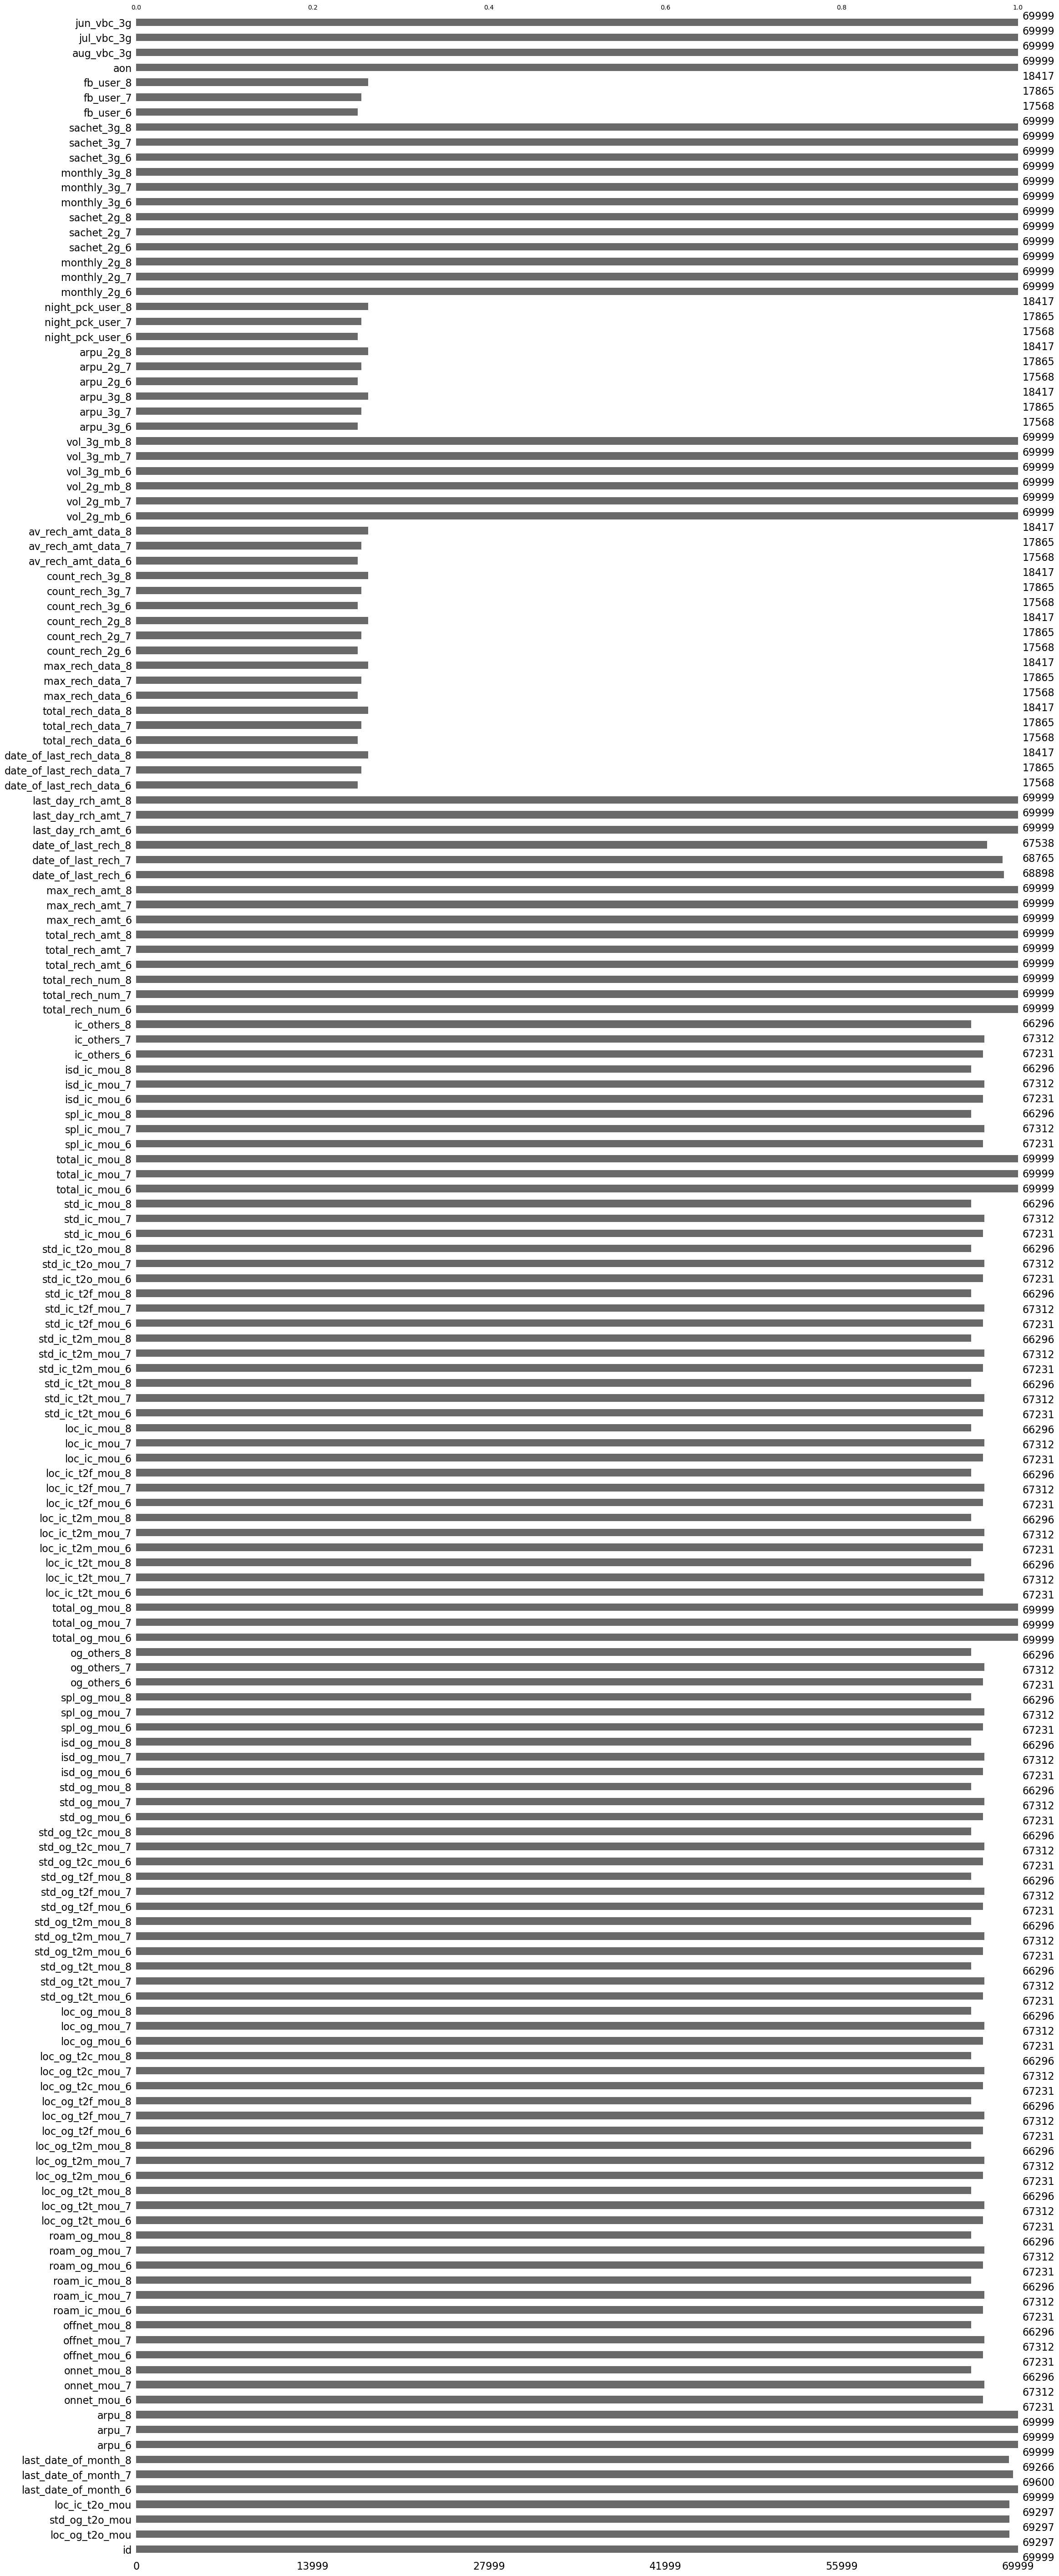

In [8]:
msno.bar(X)

In [9]:
missing_data_percent = 100*(X.isnull().sum()/len(y))
missing_data_percent

id                       0.000000
loc_og_t2o_mou           1.002871
std_og_t2o_mou           1.002871
loc_ic_t2o_mou           1.002871
last_date_of_month_6     0.000000
                          ...    
fb_user_8               73.689624
aon                      0.000000
aug_vbc_3g               0.000000
jul_vbc_3g               0.000000
jun_vbc_3g               0.000000
Length: 170, dtype: float64

In [10]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=140)

In [11]:
X_filtered = X[new_vars]
unseen_test = unseen_test[new_vars]
X_filtered.shape

(69999, 140)

In [12]:
## Let's drop the above date columns as they are not required in our analysis
# Dropping date columns
# List the date columns
date_cols = [k for k in X_filtered.columns.to_list() if 'date' in k]
print(date_cols) 
X_filtered = X_filtered.drop(date_cols, axis=1)
unseen_test = unseen_test.drop(date_cols, axis=1)

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


In [13]:
missing_data_percent = X_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
print(impute_cols)
missing_test_data_percent = unseen_test.isnull().any()
impute_test_cols = missing_test_data_percent[missing_test_data_percent.gt(0)].index
print(impute_test_cols)

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_o

In [14]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_filtered[impute_cols] = imp.fit_transform(X_filtered[impute_cols])
unseen_test[impute_test_cols] = imp.fit_transform(unseen_test[impute_test_cols])

### Exploratory Data Analysis and Data preprocessing

### Outlier Handling

In [15]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [16]:
X_filtered = X_filtered.apply(cap_outliers, axis=0)

In [17]:
X_filtered.columns

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=134)

In [18]:
X_filtered = X_filtered.drop('id', axis=1)
result = pd.DataFrame(unseen_test, columns = ['id'])
unseen_test = unseen_test.drop('id', axis=1)

#### Some columns can be combined together to get aggregated info, let's do that
total_mou_8 = total_ic_mou_8 + total_og_mou_8 <br><br>
total_roam_mou_8 = roam_ic_mou_8 + roam_og_mou_8<br><br>
total_loc_t2m_mou_8 = loc_ic_t2m_mou_8 + loc_og_t2m_mou_8<br><br>
total_loc_t2t_mou_8 = loc_ic_t2t_mou_8 + loc_og_t2t_mou_8<br><br>
totla_loc_t2f_mou_8 = loc_ic_t2f_mou_8 + loc_og_t2f_mou_8<br><br>
total_loc_mou_8 = loc_ic_mou_8 + loc_og_mou_8<br><br>
total_std_mou_8 = std_ic_mou_8 + std_og_mou_8<br><br>
total_std_t2m_mou_8 = std_ic_t2m_mou_8 + std_og_t2m_mou_8<br><br>
total_std_t2t_mou_8 = std_ic_t2t_mou_8 + std_og_t2t_mou_8<br><br>
total_std_t2f_mou_8 = std_ic_t2f_mou_8 + std_og_t2f_mou_8<br><br>
total_spl_mou_8 = spl_ic_mou_8 + spl_og_mou_8<br><br>
total_others_mou_8 = ic_others_8 + og_others_8<br><br>
total_isd_mou_8 = isd_ic_mou_8 + isd_og_mou_8<br><br>
<br><br>
//Same thing for month of June and July

In [19]:
X_filtered['total_mou_8'] = X_filtered['total_ic_mou_8'] + X_filtered['total_og_mou_8']
X_filtered['total_roam_mou_8'] = X_filtered['roam_ic_mou_8'] + X_filtered['roam_og_mou_8']
X_filtered['total_loc_t2m_mou_8'] = X_filtered['loc_ic_t2m_mou_8'] + X_filtered['loc_og_t2m_mou_8']
X_filtered['total_loc_t2t_mou_8'] = X_filtered['loc_ic_t2t_mou_8'] + X_filtered['loc_og_t2t_mou_8']
X_filtered['total_loc_t2f_mou_8'] = X_filtered['loc_ic_t2f_mou_8'] + X_filtered['loc_og_t2f_mou_8']
X_filtered['total_loc_mou_8'] = X_filtered['loc_ic_mou_8'] + X_filtered['loc_og_mou_8']
X_filtered['total_std_mou_8'] = X_filtered['std_ic_mou_8'] + X_filtered['std_og_mou_8']
X_filtered['total_std_t2m_mou_8'] = X_filtered['std_ic_t2m_mou_8'] + X_filtered['std_og_t2m_mou_8']
X_filtered['total_std_t2t_mou_8'] = X_filtered['std_ic_t2t_mou_8'] + X_filtered['std_og_t2t_mou_8']
X_filtered['total_std_t2f_mou_8'] = X_filtered['std_ic_t2f_mou_8'] + X_filtered['std_og_t2f_mou_8']
X_filtered['total_spl_mou_8'] = X_filtered['spl_ic_mou_8'] + X_filtered['spl_og_mou_8']
X_filtered['total_others_mou_8'] = X_filtered['ic_others_8'] + X_filtered['og_others_8']
X_filtered['total_isd_mou_8'] = X_filtered['isd_ic_mou_8'] + X_filtered['isd_og_mou_8']

X_filtered['total_mou_7'] = X_filtered['total_ic_mou_7'] + X_filtered['total_og_mou_7']
X_filtered['total_roam_mou_7'] = X_filtered['roam_ic_mou_7'] + X_filtered['roam_og_mou_7']
X_filtered['total_loc_t2m_mou_7'] = X_filtered['loc_ic_t2m_mou_7'] + X_filtered['loc_og_t2m_mou_7']
X_filtered['total_loc_t2t_mou_7'] = X_filtered['loc_ic_t2t_mou_7'] + X_filtered['loc_og_t2t_mou_7']
X_filtered['total_loc_t2f_mou_7'] = X_filtered['loc_ic_t2f_mou_7'] + X_filtered['loc_og_t2f_mou_7']
X_filtered['total_loc_mou_7'] = X_filtered['loc_ic_mou_7'] + X_filtered['loc_og_mou_7']
X_filtered['total_std_mou_7'] = X_filtered['std_ic_mou_7'] + X_filtered['std_og_mou_7']
X_filtered['total_std_t2m_mou_7'] = X_filtered['std_ic_t2m_mou_7'] + X_filtered['std_og_t2m_mou_7']
X_filtered['total_std_t2t_mou_7'] = X_filtered['std_ic_t2t_mou_7'] + X_filtered['std_og_t2t_mou_7']
X_filtered['total_std_t2f_mou_7'] = X_filtered['std_ic_t2f_mou_7'] + X_filtered['std_og_t2f_mou_7']
X_filtered['total_spl_mou_7'] = X_filtered['spl_ic_mou_7'] + X_filtered['spl_og_mou_7']
X_filtered['total_others_mou_7'] = X_filtered['ic_others_7'] + X_filtered['og_others_7']
X_filtered['total_isd_mou_7'] = X_filtered['isd_ic_mou_7'] + X_filtered['isd_og_mou_7']

X_filtered['total_mou_6'] = X_filtered['total_ic_mou_6'] + X_filtered['total_og_mou_6']
X_filtered['total_roam_mou_6'] = X_filtered['roam_ic_mou_6'] + X_filtered['roam_og_mou_6']
X_filtered['total_loc_t2m_mou_6'] = X_filtered['loc_ic_t2m_mou_6'] + X_filtered['loc_og_t2m_mou_6']
X_filtered['total_loc_t2t_mou_6'] = X_filtered['loc_ic_t2t_mou_6'] + X_filtered['loc_og_t2t_mou_6']
X_filtered['total_loc_t2f_mou_6'] = X_filtered['loc_ic_t2f_mou_6'] + X_filtered['loc_og_t2f_mou_6']
X_filtered['total_loc_mou_6'] = X_filtered['loc_ic_mou_6'] + X_filtered['loc_og_mou_6']
X_filtered['total_std_mou_6'] = X_filtered['std_ic_mou_6'] + X_filtered['std_og_mou_6']
X_filtered['total_std_t2m_mou_6'] = X_filtered['std_ic_t2m_mou_6'] + X_filtered['std_og_t2m_mou_6']
X_filtered['total_std_t2t_mou_6'] = X_filtered['std_ic_t2t_mou_6'] + X_filtered['std_og_t2t_mou_6']
X_filtered['total_std_t2f_mou_6'] = X_filtered['std_ic_t2f_mou_6'] + X_filtered['std_og_t2f_mou_6']
X_filtered['total_spl_mou_6'] = X_filtered['spl_ic_mou_6'] + X_filtered['spl_og_mou_6']
X_filtered['total_others_mou_6'] = X_filtered['ic_others_6'] + X_filtered['og_others_6']
X_filtered['total_isd_mou_6'] = X_filtered['isd_ic_mou_6'] + X_filtered['isd_og_mou_6']

In [20]:
drop_more_cols = ['total_ic_mou_8', 'total_og_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_ic_t2m_mou_8', 'loc_og_t2m_mou_8', 'loc_ic_t2t_mou_8', 'loc_og_t2t_mou_8',
'loc_ic_t2f_mou_8', 'loc_og_t2f_mou_8', 'loc_ic_mou_8', 'loc_og_mou_8', 'std_ic_mou_8', 'std_og_mou_8', 'std_ic_t2m_mou_8', 'std_og_t2m_mou_8', 'std_ic_t2t_mou_8', 'std_og_t2t_mou_8',
'std_ic_t2f_mou_8', 'std_og_t2f_mou_8', 'spl_ic_mou_8', 'spl_og_mou_8', 'ic_others_8', 'og_others_8', 'isd_ic_mou_8', 'isd_og_mou_8',
'total_ic_mou_7', 'total_og_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_ic_t2m_mou_7', 'loc_og_t2m_mou_7', 'loc_ic_t2t_mou_7', 'loc_og_t2t_mou_7',
'loc_ic_t2f_mou_7', 'loc_og_t2f_mou_7', 'loc_ic_mou_7', 'loc_og_mou_7', 'std_ic_mou_7', 'std_og_mou_7', 'std_ic_t2m_mou_7', 'std_og_t2m_mou_7', 'std_ic_t2t_mou_7', 'std_og_t2t_mou_7',
'std_ic_t2f_mou_7', 'std_og_t2f_mou_7', 'spl_ic_mou_7', 'spl_og_mou_7', 'ic_others_7', 'og_others_7', 'isd_ic_mou_7', 'isd_og_mou_7',
'total_ic_mou_6', 'total_og_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_ic_t2m_mou_6', 'loc_og_t2m_mou_6', 'loc_ic_t2t_mou_6', 'loc_og_t2t_mou_6',
'loc_ic_t2f_mou_6', 'loc_og_t2f_mou_6', 'loc_ic_mou_6', 'loc_og_mou_6', 'std_ic_mou_6', 'std_og_mou_6', 'std_ic_t2m_mou_6', 'std_og_t2m_mou_6', 'std_ic_t2t_mou_6', 'std_og_t2t_mou_6',
'std_ic_t2f_mou_6', 'std_og_t2f_mou_6', 'spl_ic_mou_6', 'spl_og_mou_6', 'ic_others_6', 'og_others_6', 'isd_ic_mou_6', 'isd_og_mou_6']

X_filtered = X_filtered.drop(drop_more_cols, axis=1)
X_filtered.shape

(69999, 94)

### Matching with test data

In [21]:
unseen_test['total_mou_8'] = unseen_test['total_ic_mou_8'] + unseen_test['total_og_mou_8']
unseen_test['total_roam_mou_8'] = unseen_test['roam_ic_mou_8'] + unseen_test['roam_og_mou_8']
unseen_test['total_loc_t2m_mou_8'] = unseen_test['loc_ic_t2m_mou_8'] + unseen_test['loc_og_t2m_mou_8']
unseen_test['total_loc_t2t_mou_8'] = unseen_test['loc_ic_t2t_mou_8'] + unseen_test['loc_og_t2t_mou_8']
unseen_test['total_loc_t2f_mou_8'] = unseen_test['loc_ic_t2f_mou_8'] + unseen_test['loc_og_t2f_mou_8']
unseen_test['total_loc_mou_8'] = unseen_test['loc_ic_mou_8'] + unseen_test['loc_og_mou_8']
unseen_test['total_std_mou_8'] = unseen_test['std_ic_mou_8'] + unseen_test['std_og_mou_8']
unseen_test['total_std_t2m_mou_8'] = unseen_test['std_ic_t2m_mou_8'] + unseen_test['std_og_t2m_mou_8']
unseen_test['total_std_t2t_mou_8'] = unseen_test['std_ic_t2t_mou_8'] + unseen_test['std_og_t2t_mou_8']
unseen_test['total_std_t2f_mou_8'] = unseen_test['std_ic_t2f_mou_8'] + unseen_test['std_og_t2f_mou_8']
unseen_test['total_spl_mou_8'] = unseen_test['spl_ic_mou_8'] + unseen_test['spl_og_mou_8']
unseen_test['total_others_mou_8'] = unseen_test['ic_others_8'] + unseen_test['og_others_8']
unseen_test['total_isd_mou_8'] = unseen_test['isd_ic_mou_8'] + unseen_test['isd_og_mou_8']

unseen_test['total_mou_7'] = unseen_test['total_ic_mou_7'] + unseen_test['total_og_mou_7']
unseen_test['total_roam_mou_7'] = unseen_test['roam_ic_mou_7'] + unseen_test['roam_og_mou_7']
unseen_test['total_loc_t2m_mou_7'] = unseen_test['loc_ic_t2m_mou_7'] + unseen_test['loc_og_t2m_mou_7']
unseen_test['total_loc_t2t_mou_7'] = unseen_test['loc_ic_t2t_mou_7'] + unseen_test['loc_og_t2t_mou_7']
unseen_test['total_loc_t2f_mou_7'] = unseen_test['loc_ic_t2f_mou_7'] + unseen_test['loc_og_t2f_mou_7']
unseen_test['total_loc_mou_7'] = unseen_test['loc_ic_mou_7'] + unseen_test['loc_og_mou_7']
unseen_test['total_std_mou_7'] = unseen_test['std_ic_mou_7'] + unseen_test['std_og_mou_7']
unseen_test['total_std_t2m_mou_7'] = unseen_test['std_ic_t2m_mou_7'] + unseen_test['std_og_t2m_mou_7']
unseen_test['total_std_t2t_mou_7'] = unseen_test['std_ic_t2t_mou_7'] + unseen_test['std_og_t2t_mou_7']
unseen_test['total_std_t2f_mou_7'] = unseen_test['std_ic_t2f_mou_7'] + unseen_test['std_og_t2f_mou_7']
unseen_test['total_spl_mou_7'] = unseen_test['spl_ic_mou_7'] + unseen_test['spl_og_mou_7']
unseen_test['total_others_mou_7'] = unseen_test['ic_others_7'] + unseen_test['og_others_7']
unseen_test['total_isd_mou_7'] = unseen_test['isd_ic_mou_7'] + unseen_test['isd_og_mou_7']

unseen_test['total_mou_6'] = unseen_test['total_ic_mou_6'] + unseen_test['total_og_mou_6']
unseen_test['total_roam_mou_6'] = unseen_test['roam_ic_mou_6'] + unseen_test['roam_og_mou_6']
unseen_test['total_loc_t2m_mou_6'] = unseen_test['loc_ic_t2m_mou_6'] + unseen_test['loc_og_t2m_mou_6']
unseen_test['total_loc_t2t_mou_6'] = unseen_test['loc_ic_t2t_mou_6'] + unseen_test['loc_og_t2t_mou_6']
unseen_test['total_loc_t2f_mou_6'] = unseen_test['loc_ic_t2f_mou_6'] + unseen_test['loc_og_t2f_mou_6']
unseen_test['total_loc_mou_6'] = unseen_test['loc_ic_mou_6'] + unseen_test['loc_og_mou_6']
unseen_test['total_std_mou_6'] = unseen_test['std_ic_mou_6'] + unseen_test['std_og_mou_6']
unseen_test['total_std_t2m_mou_6'] = unseen_test['std_ic_t2m_mou_6'] + unseen_test['std_og_t2m_mou_6']
unseen_test['total_std_t2t_mou_6'] = unseen_test['std_ic_t2t_mou_6'] + unseen_test['std_og_t2t_mou_6']
unseen_test['total_std_t2f_mou_6'] = unseen_test['std_ic_t2f_mou_6'] + unseen_test['std_og_t2f_mou_6']
unseen_test['total_spl_mou_6'] = unseen_test['spl_ic_mou_6'] + unseen_test['spl_og_mou_6']
unseen_test['total_others_mou_6'] = unseen_test['ic_others_6'] + unseen_test['og_others_6']
unseen_test['total_isd_mou_6'] = unseen_test['isd_ic_mou_6'] + unseen_test['isd_og_mou_6']

In [22]:
unseen_test = unseen_test.drop(drop_more_cols, axis=1)
unseen_test.shape

(30000, 94)

#### Scaling the variables : 

<Axes: >

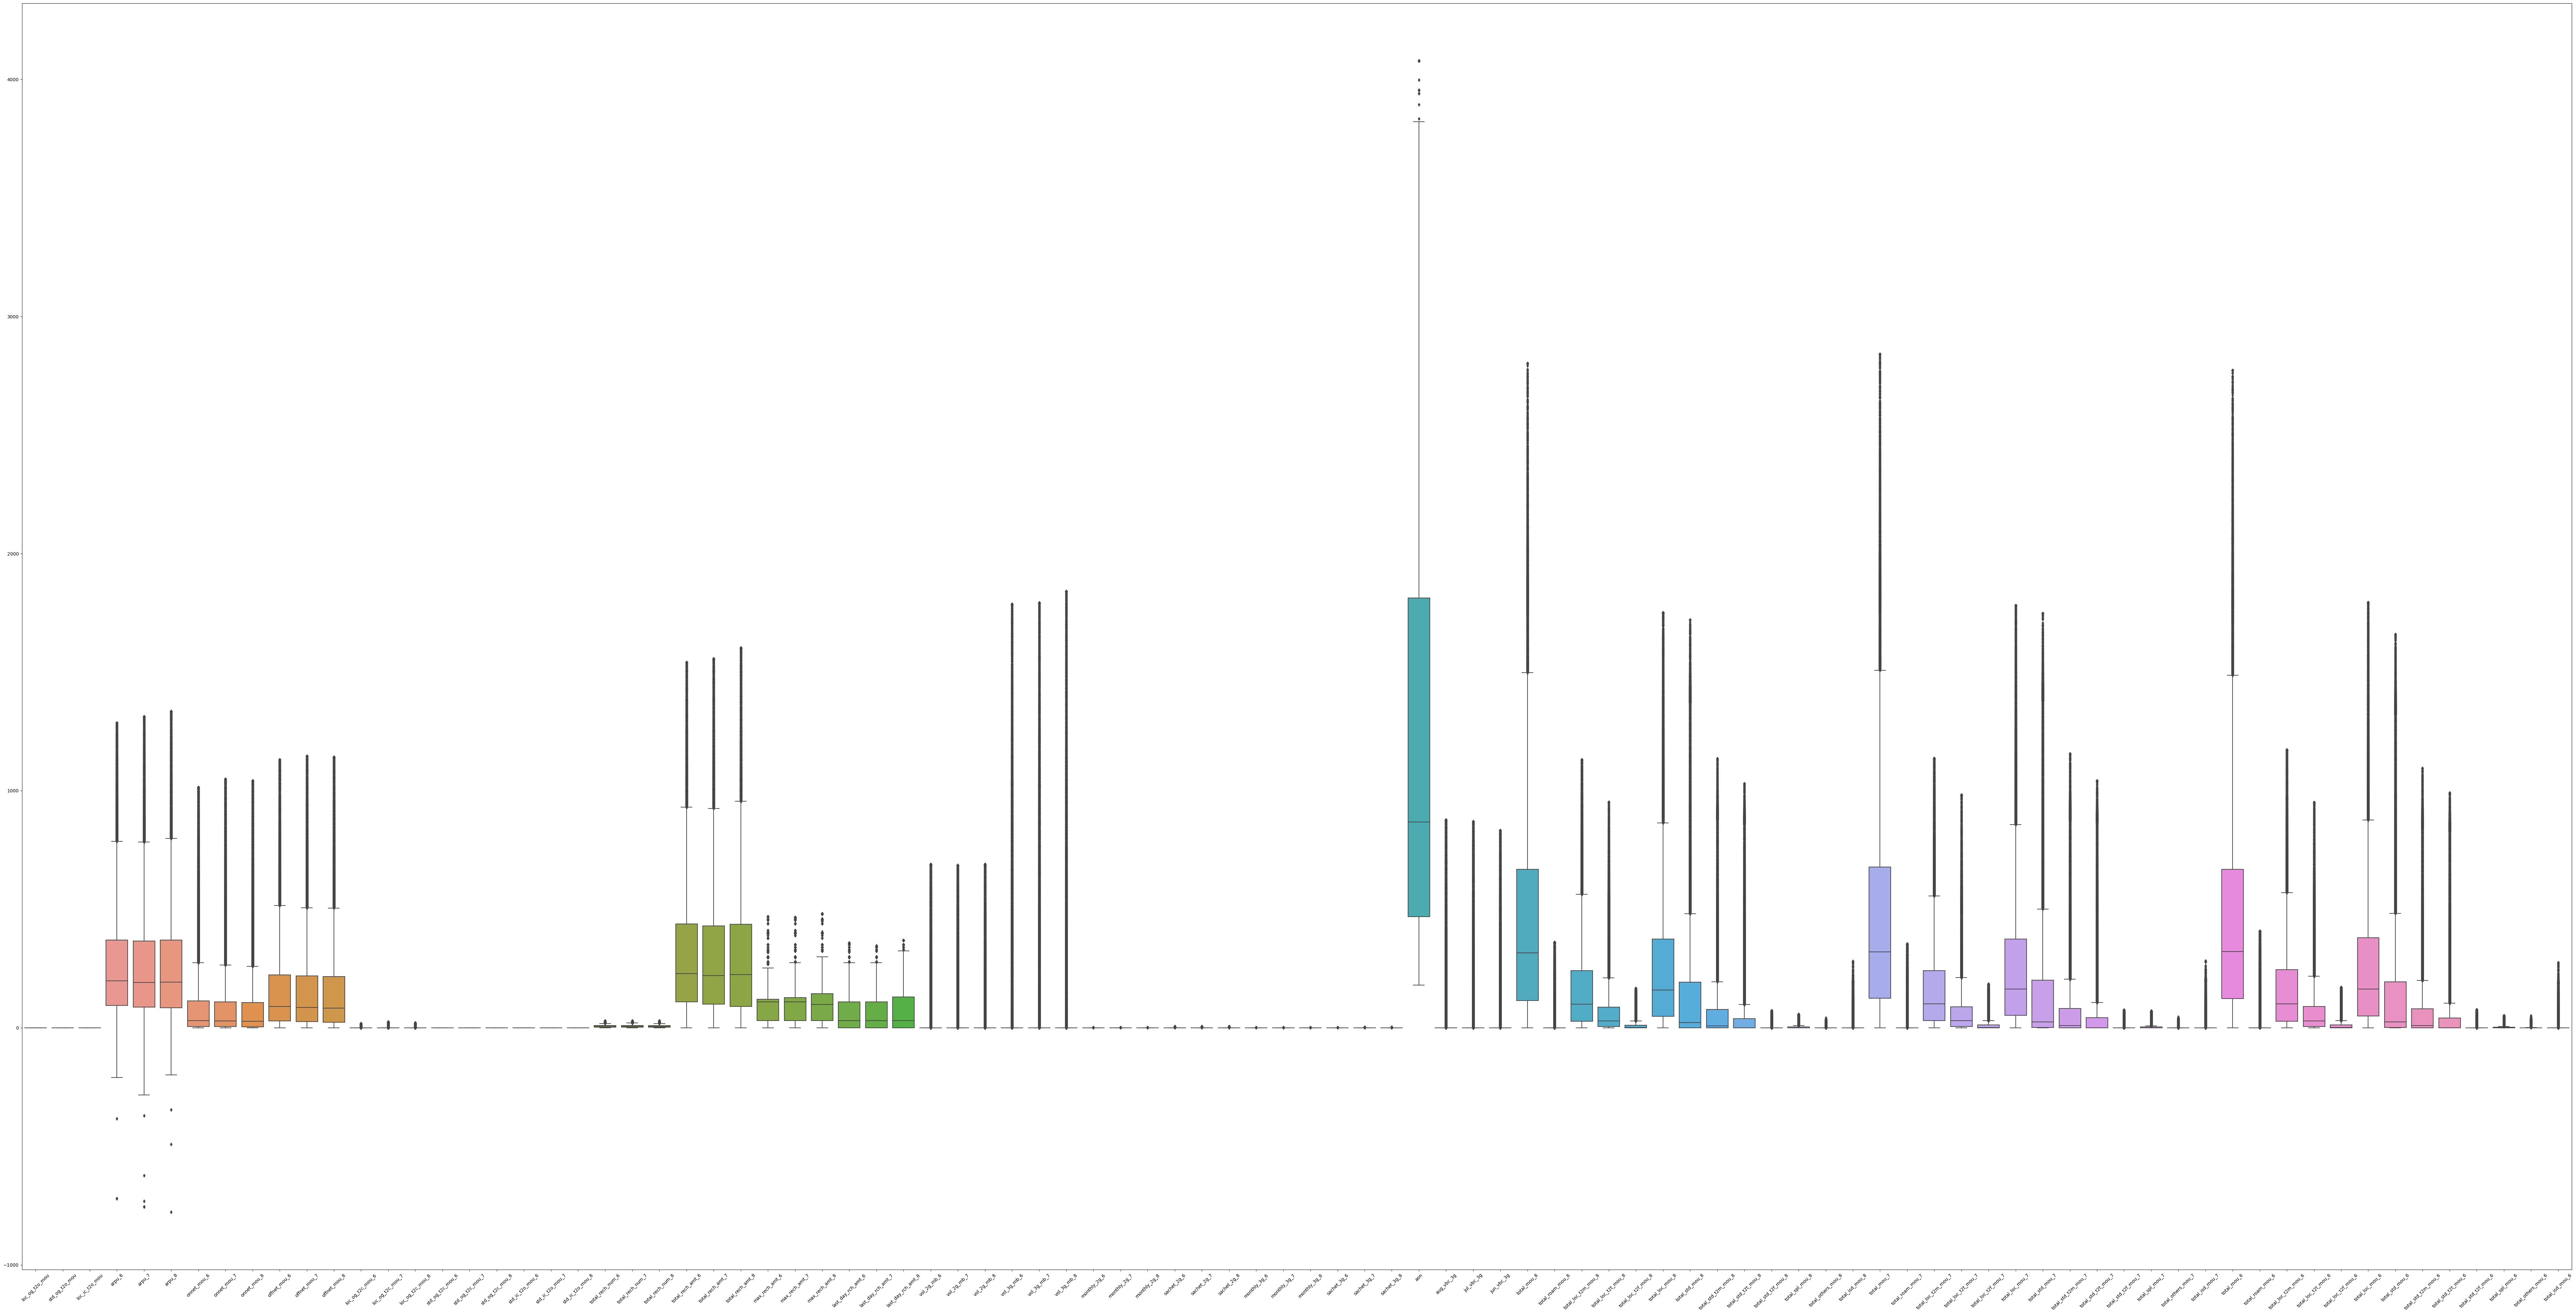

In [23]:
plt.figure(figsize=(100,50))
plt.xticks(rotation=45)
sns.boxplot(data = X_filtered)

In [24]:
cols = X_filtered.columns
X_train, X_validation, y_train, y_validation = train_test_split(X_filtered, y, test_size=0.2)

X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((55999, 94), (14000, 94), (55999,), (14000,))

In [25]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)

<Axes: >

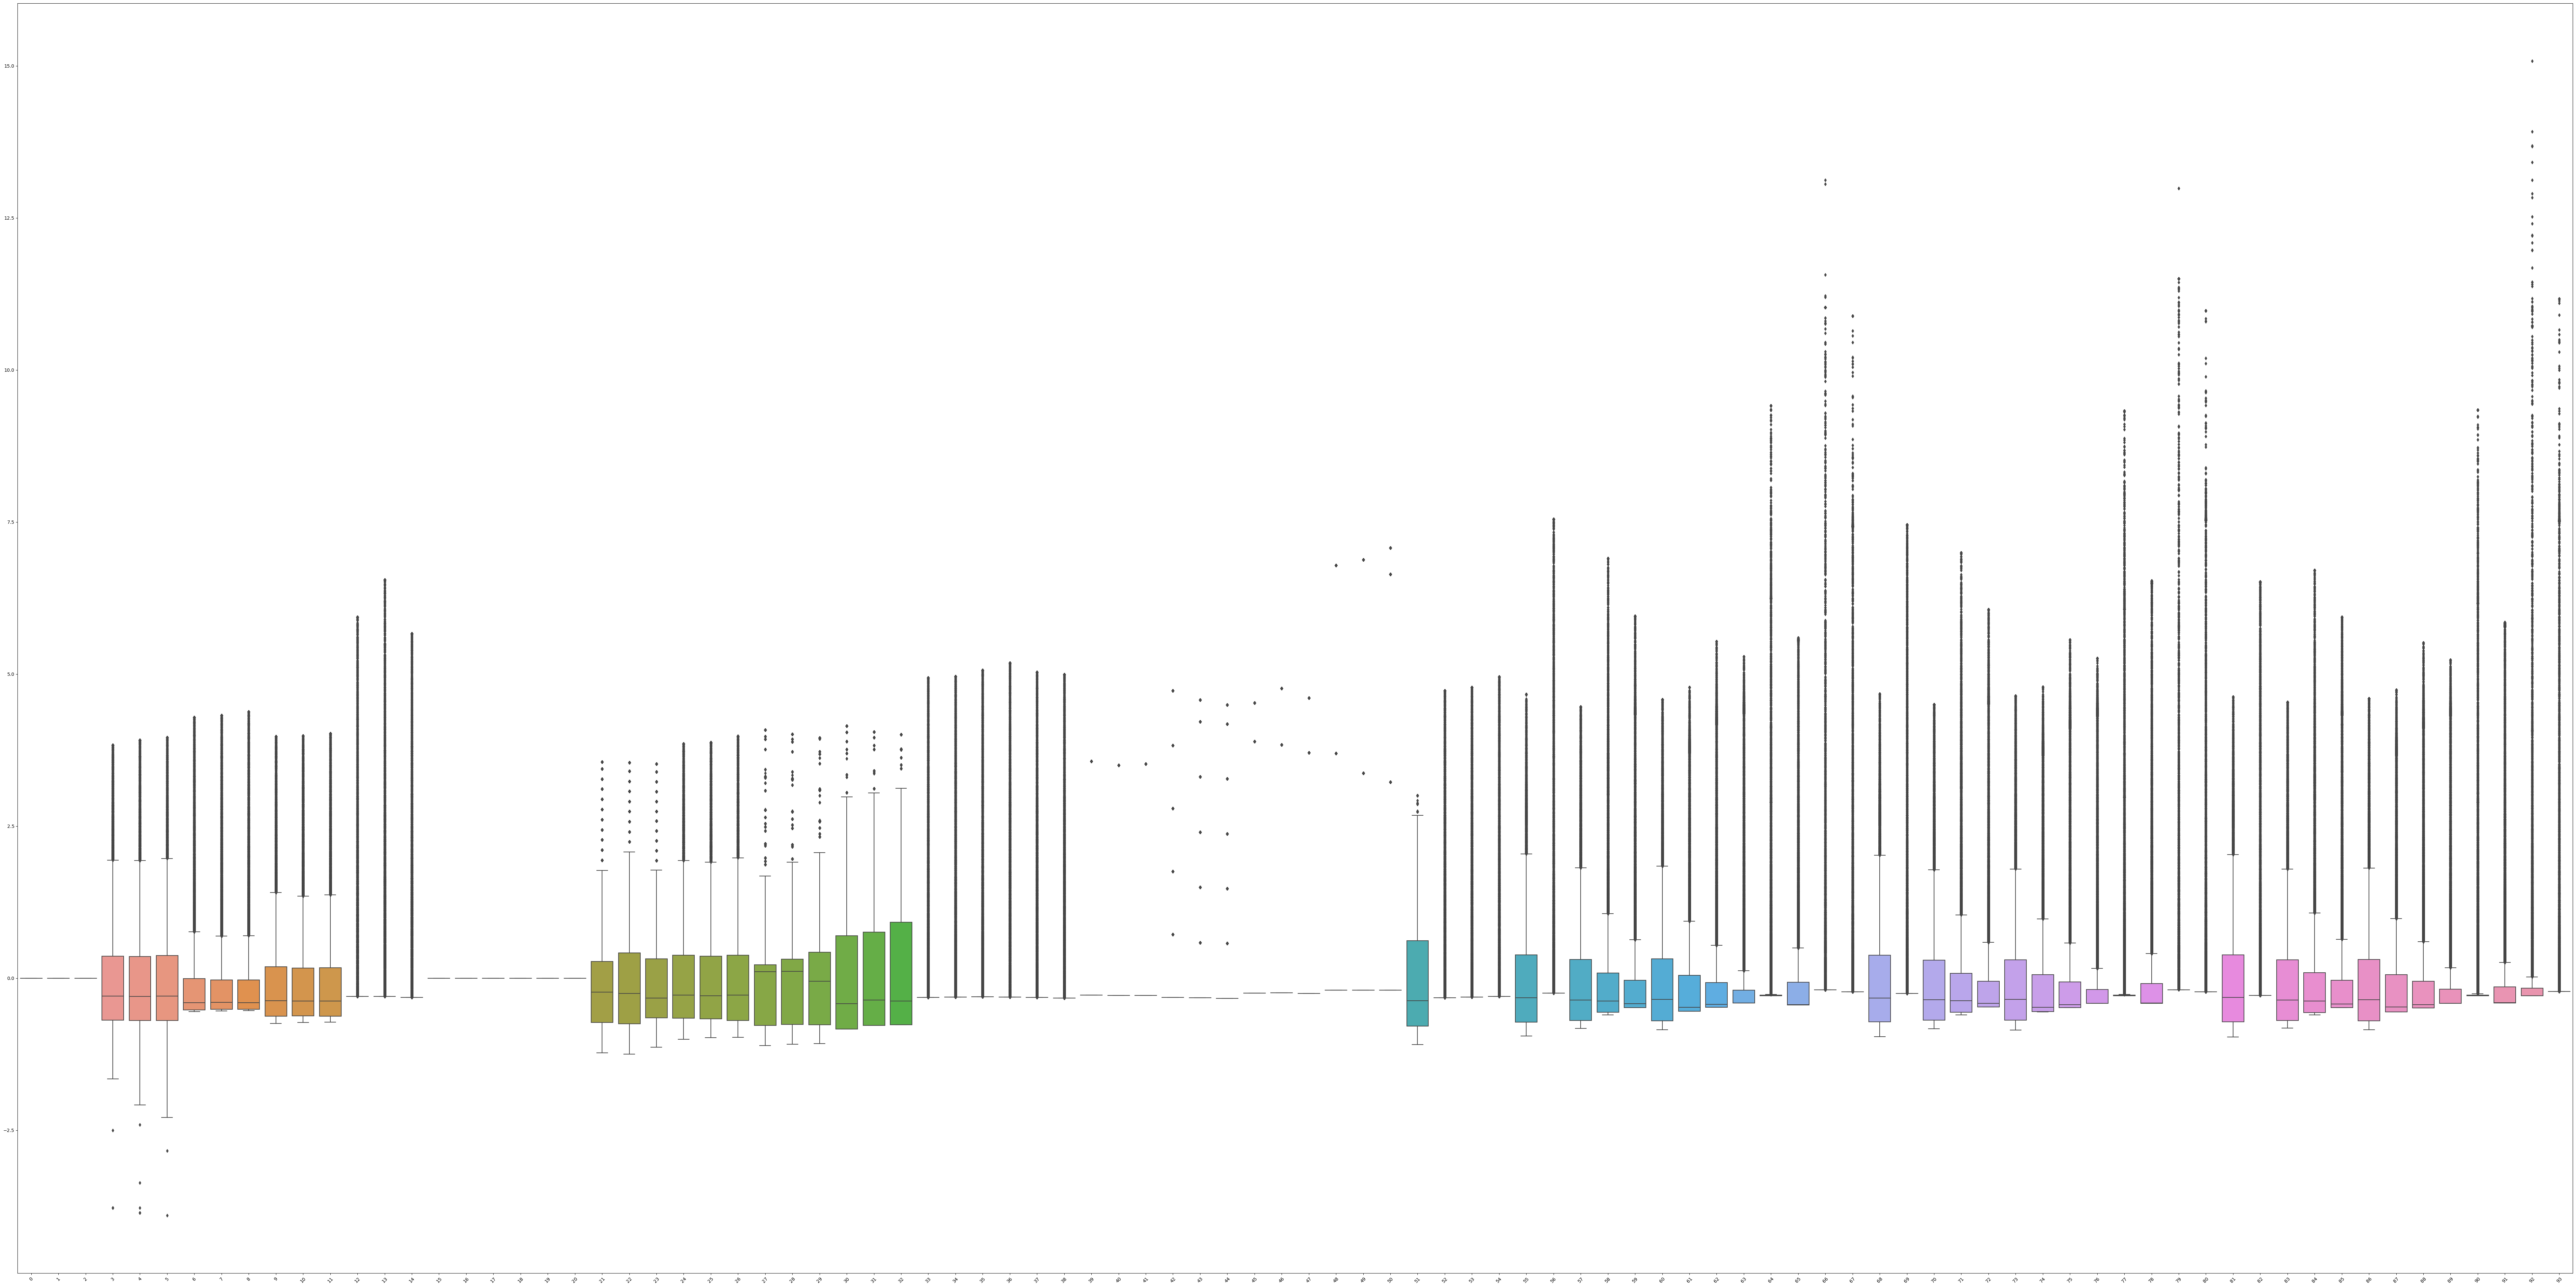

In [26]:
plt.figure(figsize=(100,50))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train))

<Axes: xlabel='churn_probability', ylabel='Count'>

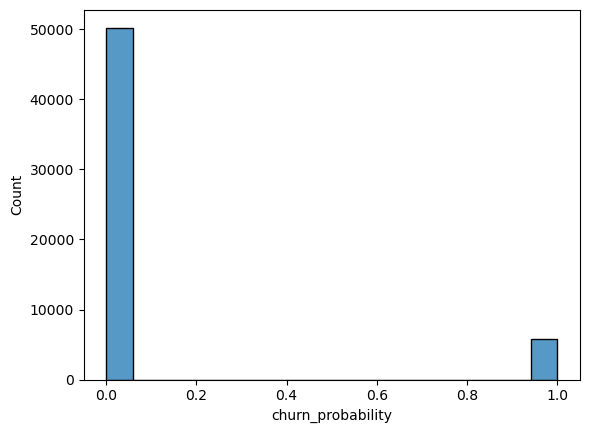

In [27]:
#Distribution for the churn probability
sns.histplot(y_train)

#### Since we have very few data with churn 1 we will use SMOTE to sample

In [28]:
# Instantiate SMOTE
sm = SMOTE(random_state=27)

In [29]:
# Fitting SMOTE to the train set
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train_oversampled, columns=cols)
y_train = y_train_oversampled

<Axes: >

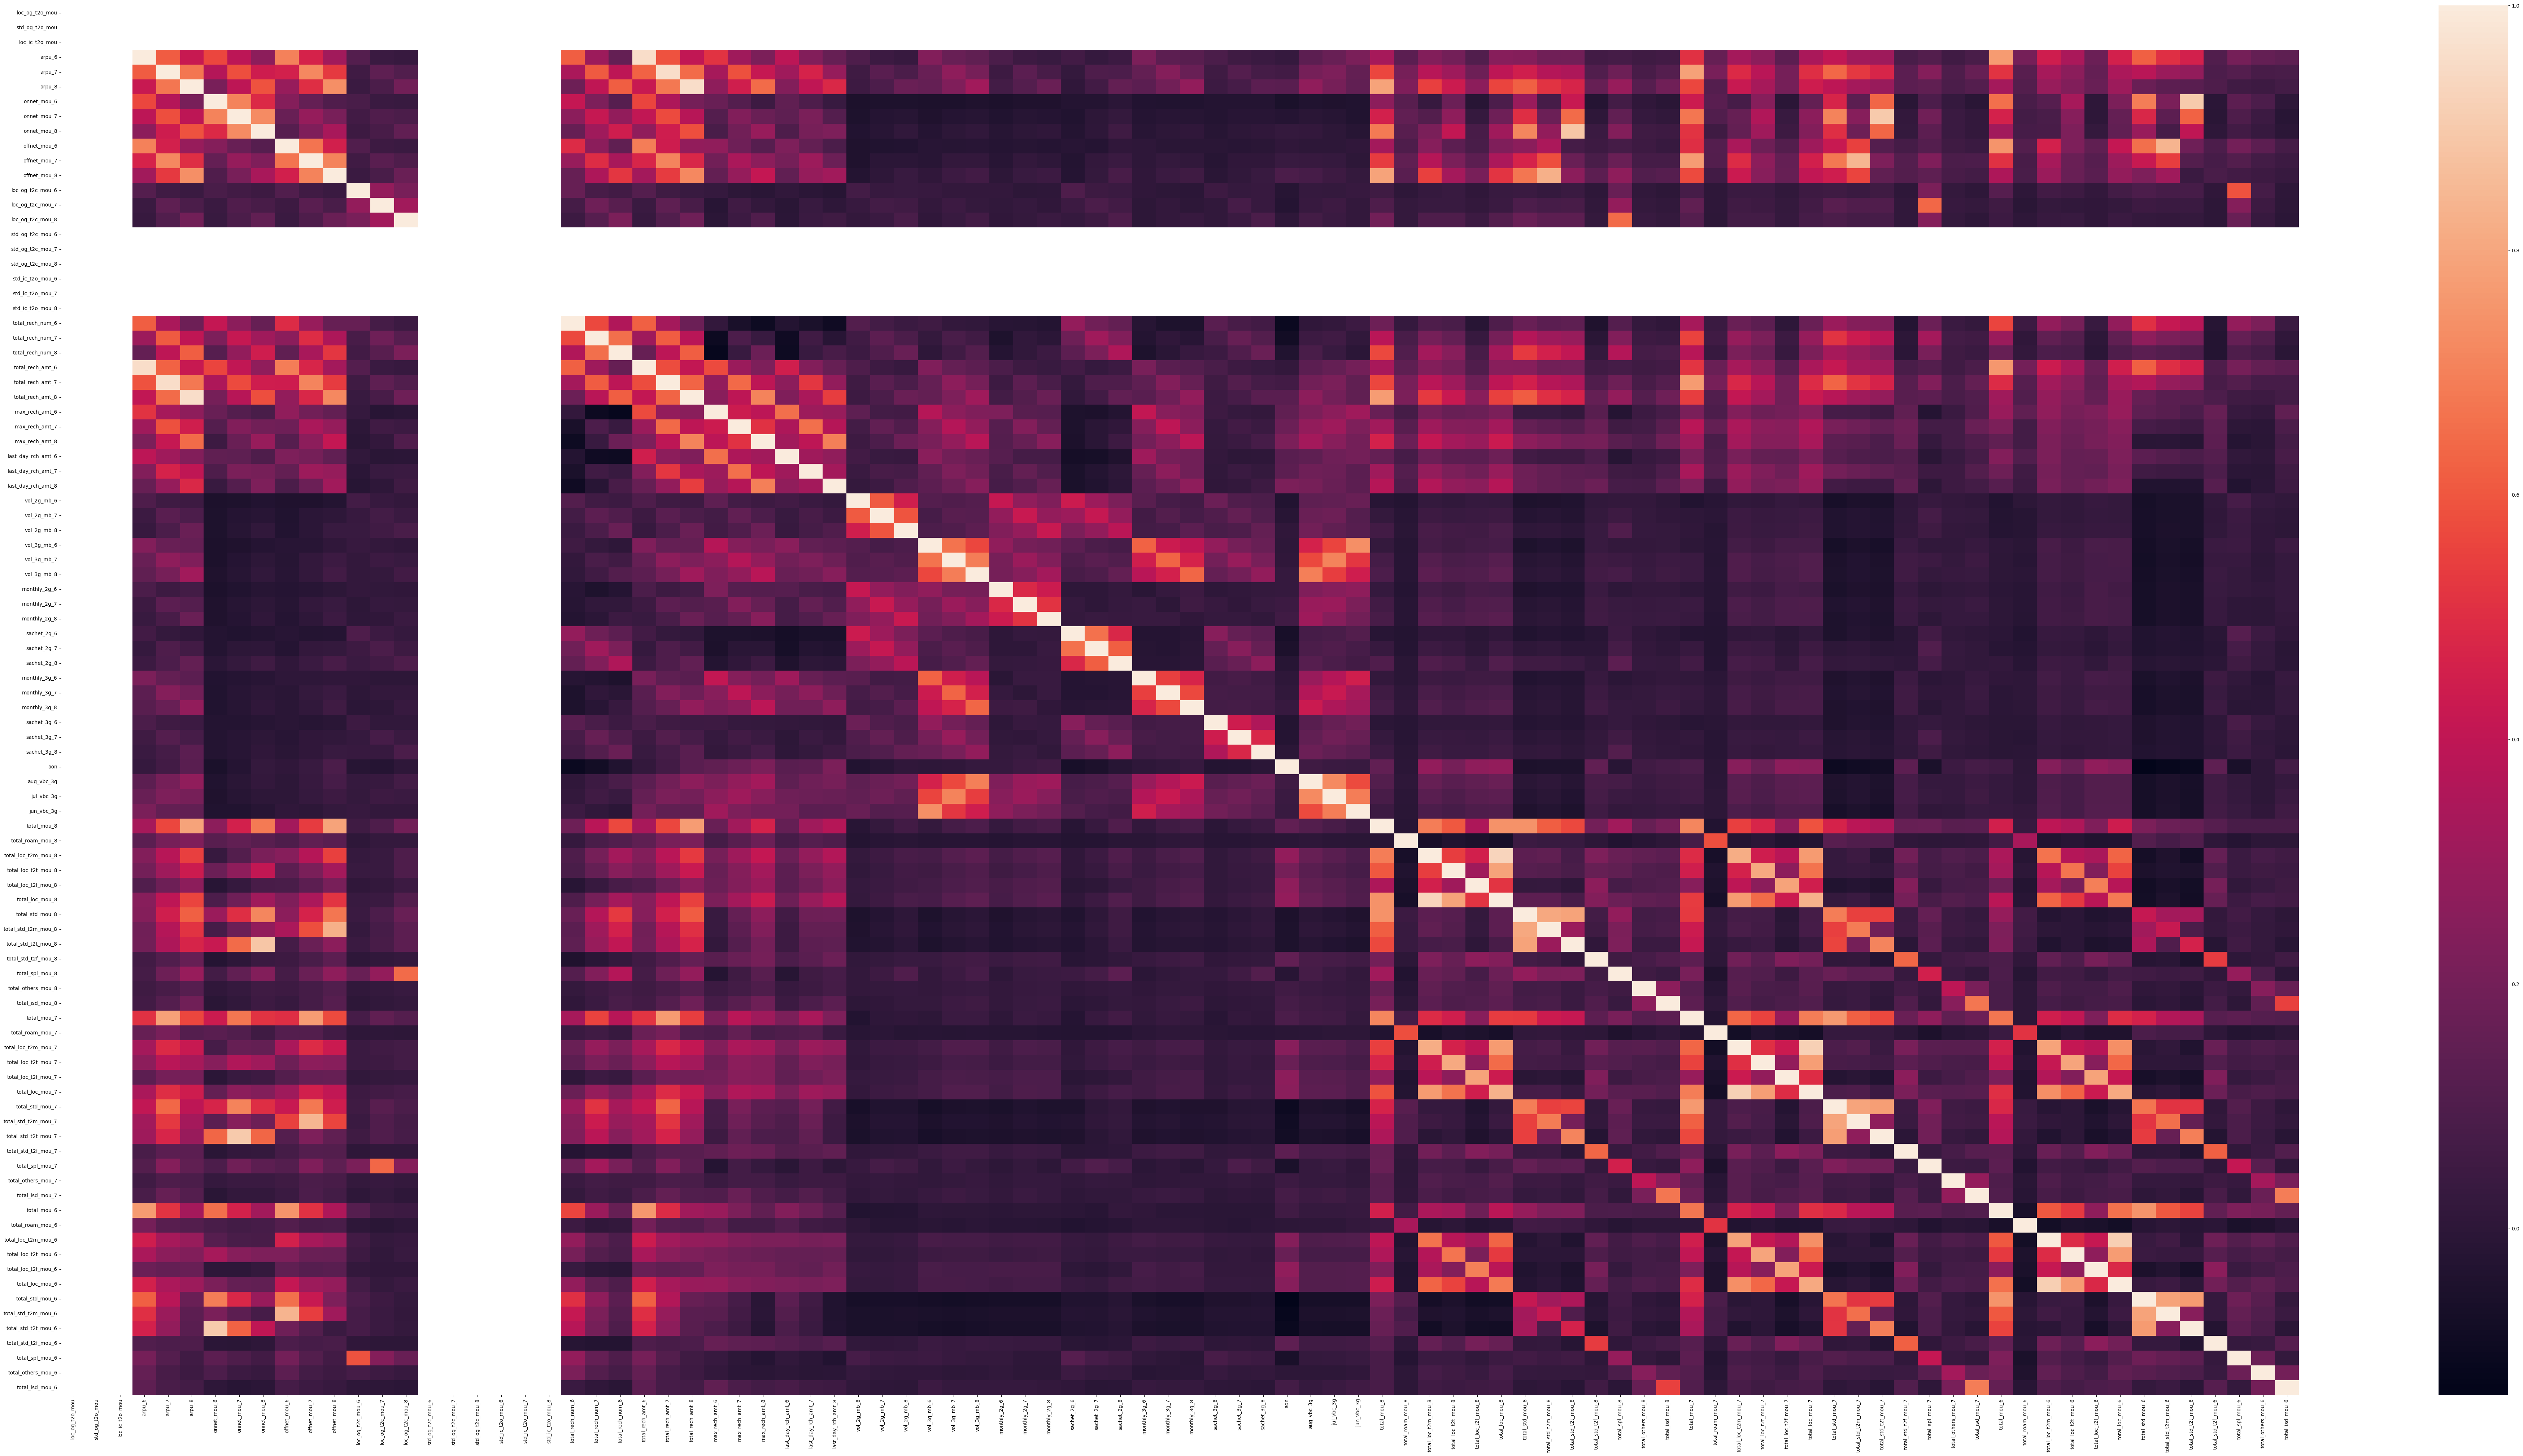

In [30]:
plt.figure(figsize=(100,50))
sns.heatmap(pd.DataFrame(X_train).corr())

#### There is a lot of corelation in the above data, we will make use of PCA

### Model Building
#### Model 1: RANDOM FOREST
##### We will start with a Random Forest classifier to establish a baseline and understand feature importance

In [31]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [32]:
rf.feature_importances_

array([0.        , 0.        , 0.        , 0.00775619, 0.00861351,
       0.04866264, 0.00624611, 0.00680927, 0.01040474, 0.00683803,
       0.00891145, 0.03113703, 0.00286253, 0.00400045, 0.00301086,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00861073, 0.00959561, 0.01758974, 0.00636041,
       0.00838404, 0.02510267, 0.00659179, 0.00871946, 0.0366555 ,
       0.00618035, 0.00852315, 0.0383883 , 0.00220733, 0.00248975,
       0.00549287, 0.0015757 , 0.00201981, 0.0039033 , 0.00070762,
       0.00097448, 0.00165255, 0.00150433, 0.00194229, 0.00376046,
       0.00081981, 0.000758  , 0.00089341, 0.00062896, 0.00079676,
       0.00105857, 0.01148091, 0.00257742, 0.00168344, 0.00180291,
       0.07458565, 0.07405193, 0.07981795, 0.05533657, 0.02148635,
       0.06416053, 0.02210462, 0.0117303 , 0.00662825, 0.00461841,
       0.00864696, 0.00410334, 0.00328416, 0.01350257, 0.01694298,
       0.01489184, 0.0115838 , 0.00521155, 0.01313072, 0.00791

In [33]:
feature_importances = pd.DataFrame({'col':cols, 'importance':rf.feature_importances_})

<BarContainer object of 94 artists>

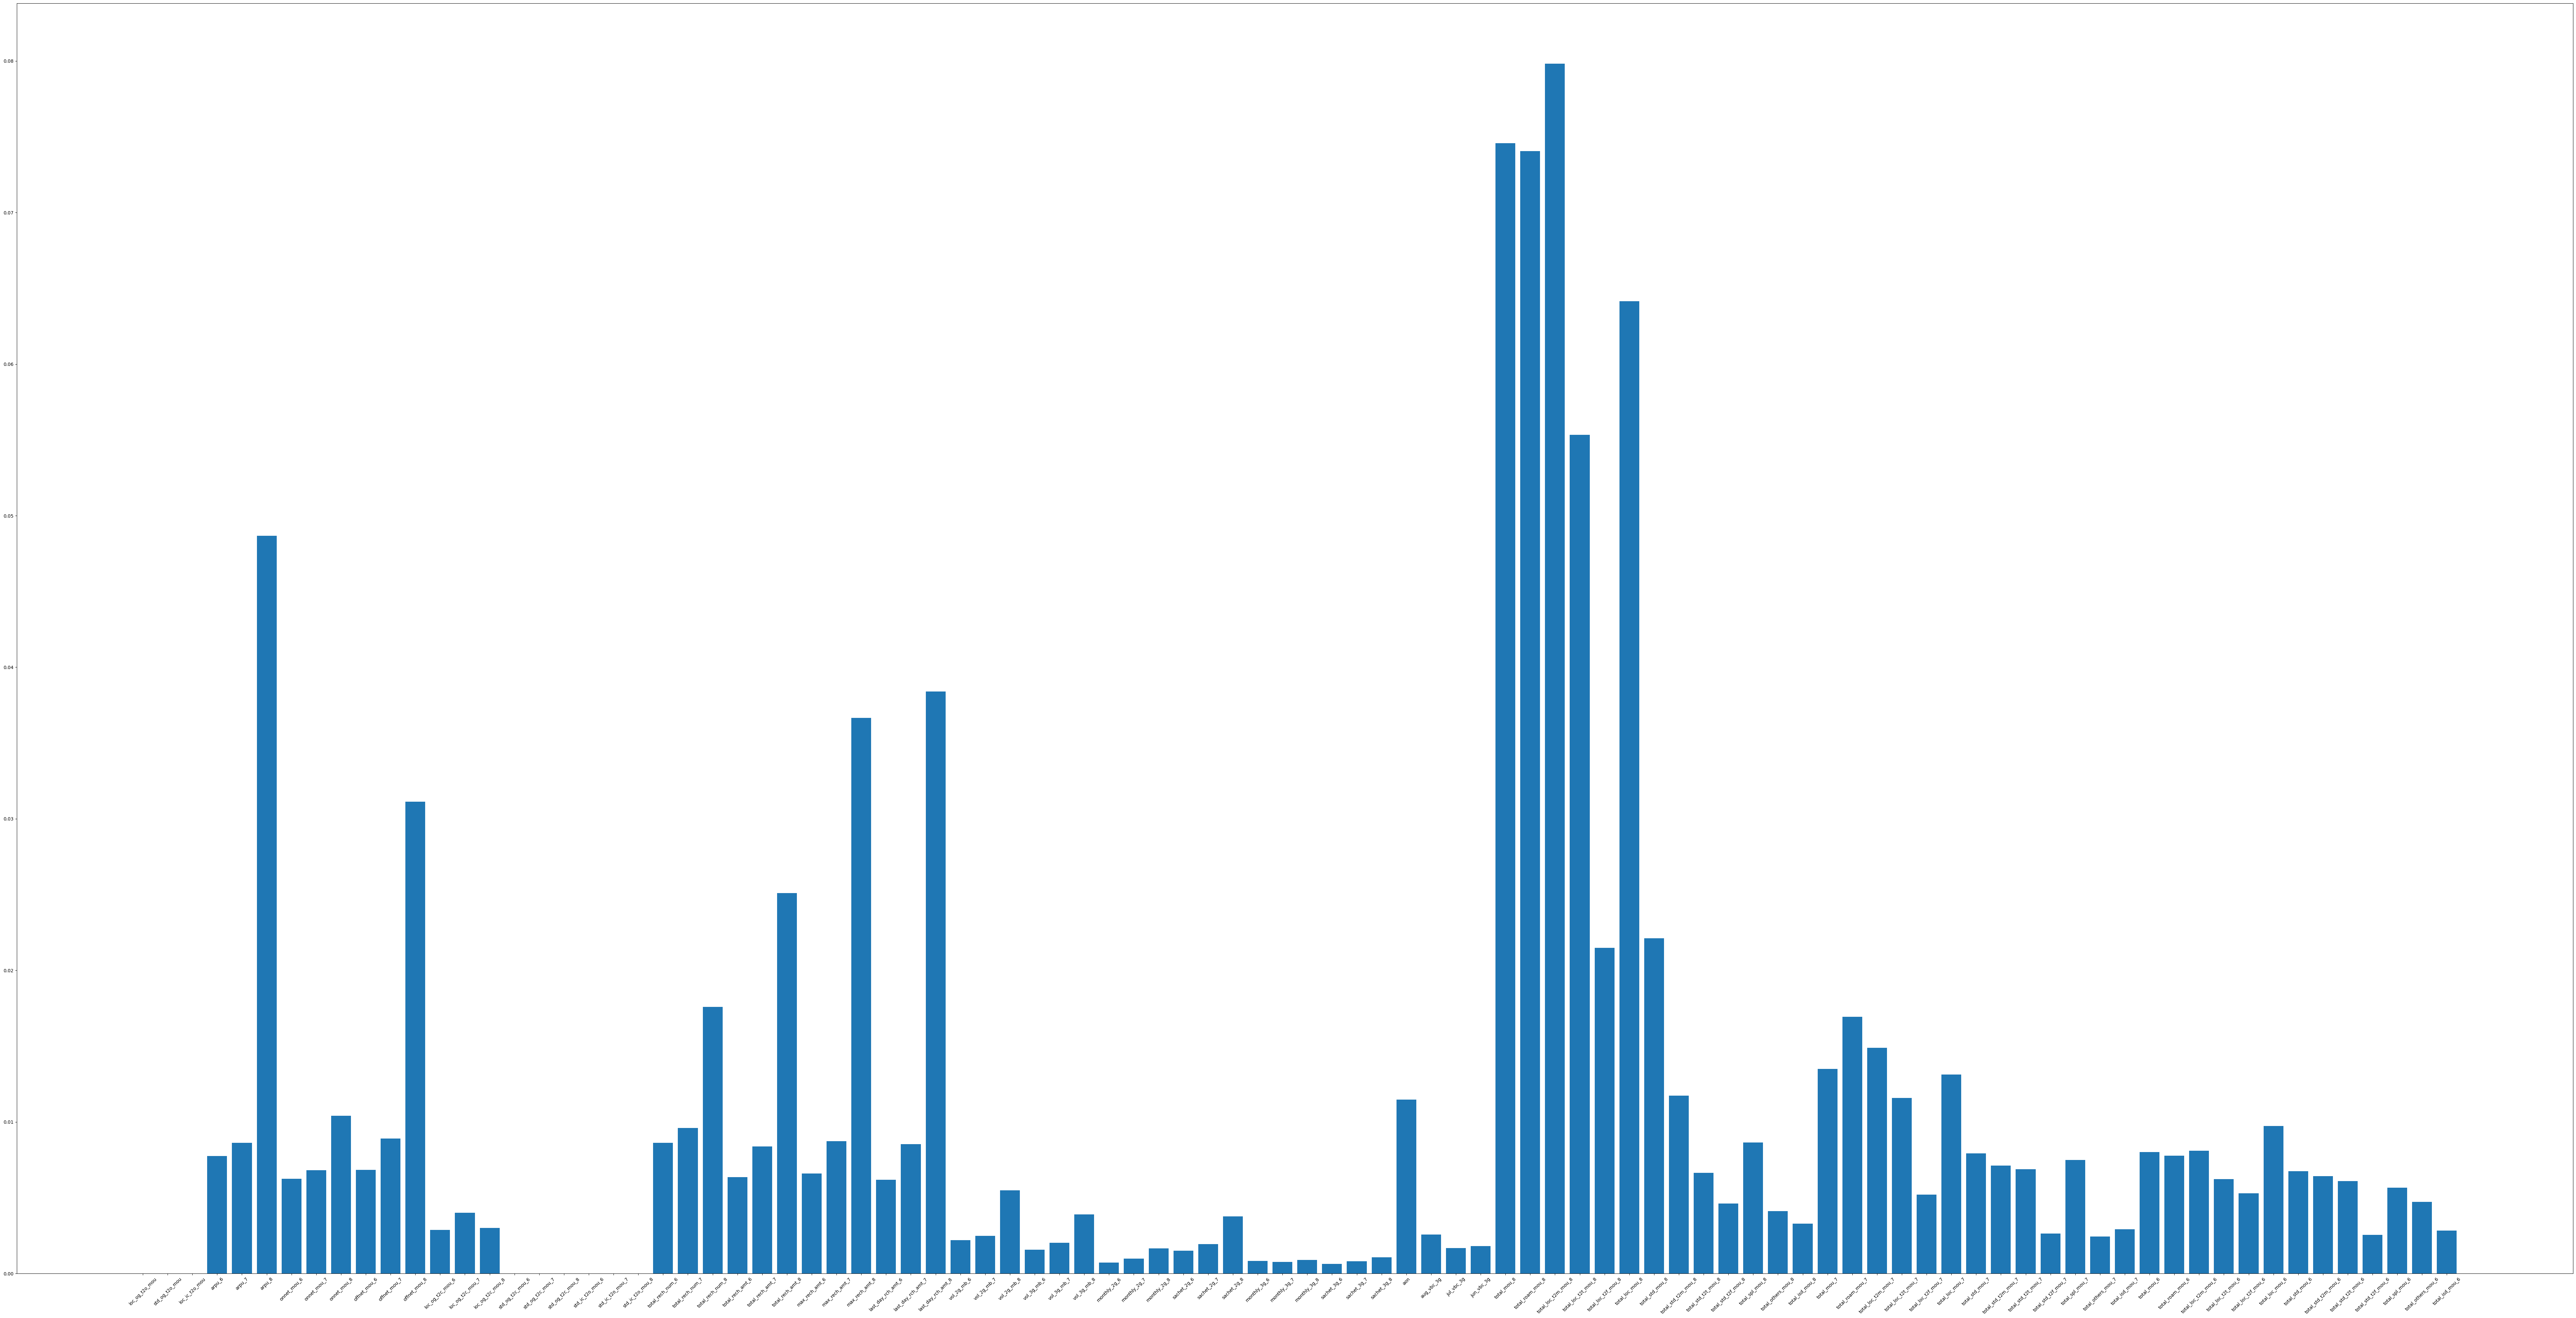

In [34]:
plt.figure(figsize=(100,50))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

In [35]:
feature_importances = feature_importances.sort_values('importance', ascending=False)

In [36]:
feature_importances

col  importance
57  total_loc_t2m_mou_8    0.079818
55          total_mou_8    0.074586
56     total_roam_mou_8    0.074052
60      total_loc_mou_8    0.064161
58  total_loc_t2t_mou_8    0.055337
..                  ...         ...
17     std_og_t2c_mou_8    0.000000
16     std_og_t2c_mou_7    0.000000
15     std_og_t2c_mou_6    0.000000
2        loc_ic_t2o_mou    0.000000
0        loc_og_t2o_mou    0.000000

[94 rows x 2 columns]

#### So the top 6 most important columns are total_loc_mou_8, total_roam_mou_8, total_mou_8, total_loc_t2t_mou_8, total_loc_t2m_mou_8, total_rech_amt_8

In [37]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    print("Train Accuracy :", accuracy_score(y_train, model.predict(X_train)))
    print("Train Precision :", precision_score(y_train, model.predict(X_train)))
    print("Train Recall :", recall_score(y_train, model.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, model.predict(X_test)))
    print("Test Precision :", precision_score(y_test, model.predict(X_test)))
    print("Test Recall :", recall_score(y_test, model.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, model.predict(X_test)))

##### We will <b>transform</b> the data of unseen test and validation on the scaler that was fit, transformed on train data

In [38]:
X_validation = scale.transform(X_validation)
unseen_test =  scale.transform(unseen_test)

#### Let's see the performance of the random forest algo

In [39]:
evaluate_model(rf, X_train, y_train, X_validation, y_validation)

Train Accuracy : 1.0
Train Precision : 1.0
Train Recall : 1.0
Train Confusion Matrix:
[[50244     0]
 [    0 50244]]
--------------------------------------------------
Test Accuracy : 0.9321428571428572
Test Precision : 0.6302623550945698
Test Recall : 0.7501815541031227
Test Confusion Matrix:
[[12017   606]
 [  344  1033]]


### Let's use PCA for dimensionality reduction : Model 2

<Axes: >

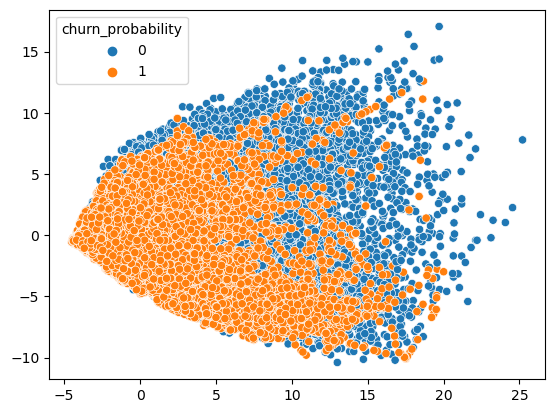

In [40]:
pca = PCA()
pca_components = pca.fit_transform(X_train)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

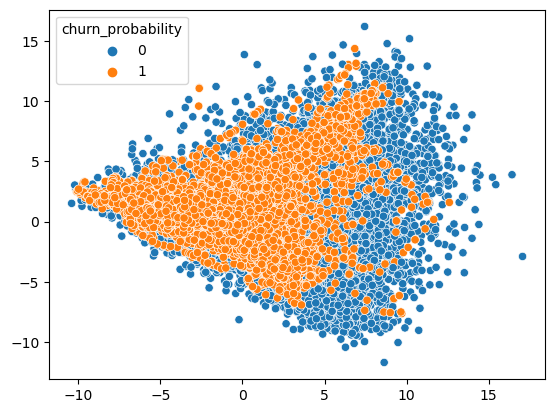

In [41]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

In [42]:
pca.explained_variance_ratio_

array([1.99937234e-01, 9.54792794e-02, 6.08307870e-02, 5.44548437e-02,
       4.59858529e-02, 4.21084628e-02, 3.47599288e-02, 2.91895961e-02,
       2.69488238e-02, 2.47931372e-02, 2.28078999e-02, 2.09606165e-02,
       1.80587221e-02, 1.58057118e-02, 1.55884751e-02, 1.50871910e-02,
       1.31456385e-02, 1.29698543e-02, 1.26680317e-02, 1.16323259e-02,
       1.11918109e-02, 1.04435923e-02, 9.87345882e-03, 9.60983055e-03,
       9.09061903e-03, 8.86176201e-03, 8.70749952e-03, 7.79776167e-03,
       7.29135773e-03, 7.08895794e-03, 6.82407084e-03, 6.71297671e-03,
       6.52051132e-03, 6.24238998e-03, 6.13870188e-03, 5.57166430e-03,
       5.42445589e-03, 5.16777013e-03, 5.06439003e-03, 4.96719528e-03,
       4.73385503e-03, 4.19762855e-03, 4.04397212e-03, 3.86494901e-03,
       3.72971048e-03, 3.55860846e-03, 3.44847100e-03, 3.37556437e-03,
       3.20717247e-03, 3.02389417e-03, 2.94213051e-03, 2.88026705e-03,
       2.81050676e-03, 2.71914512e-03, 2.56614302e-03, 2.44637122e-03,
      

#### Let's use a scree plot to explain variance

In [43]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

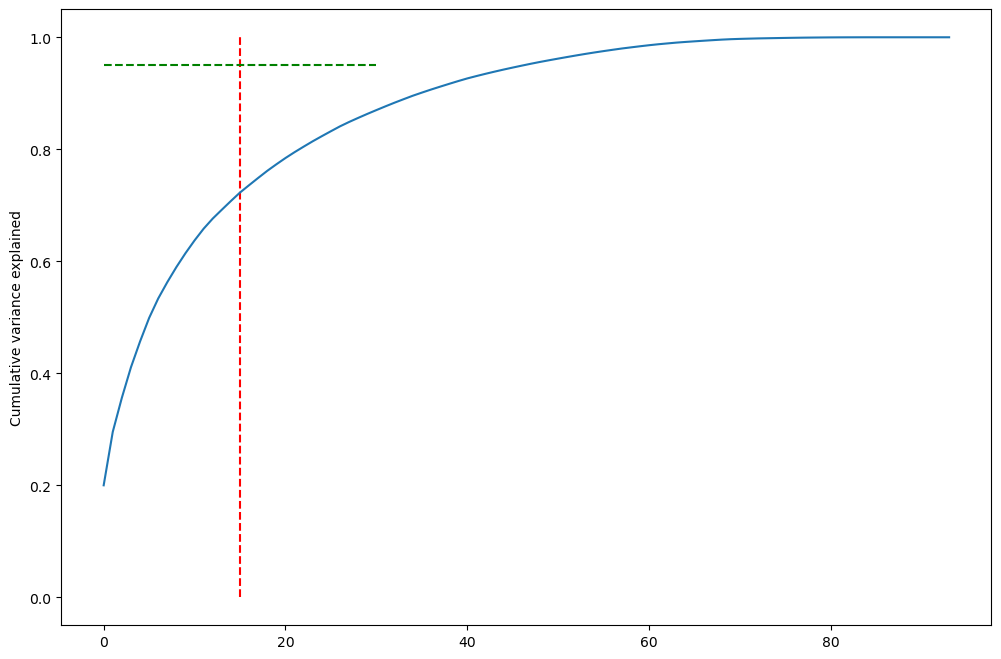

In [44]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

#### Perform PCA with 15 components

In [45]:
pca_final = IncrementalPCA(n_components=15)

In [46]:
X_train_pca = pca_final.fit_transform(X_train)

In [47]:
X_train_pca.shape

(100488, 15)

In [48]:
corrmat = np.corrcoef(X_train_pca.transpose())

In [49]:
corrmat.shape

(15, 15)

<Axes: >

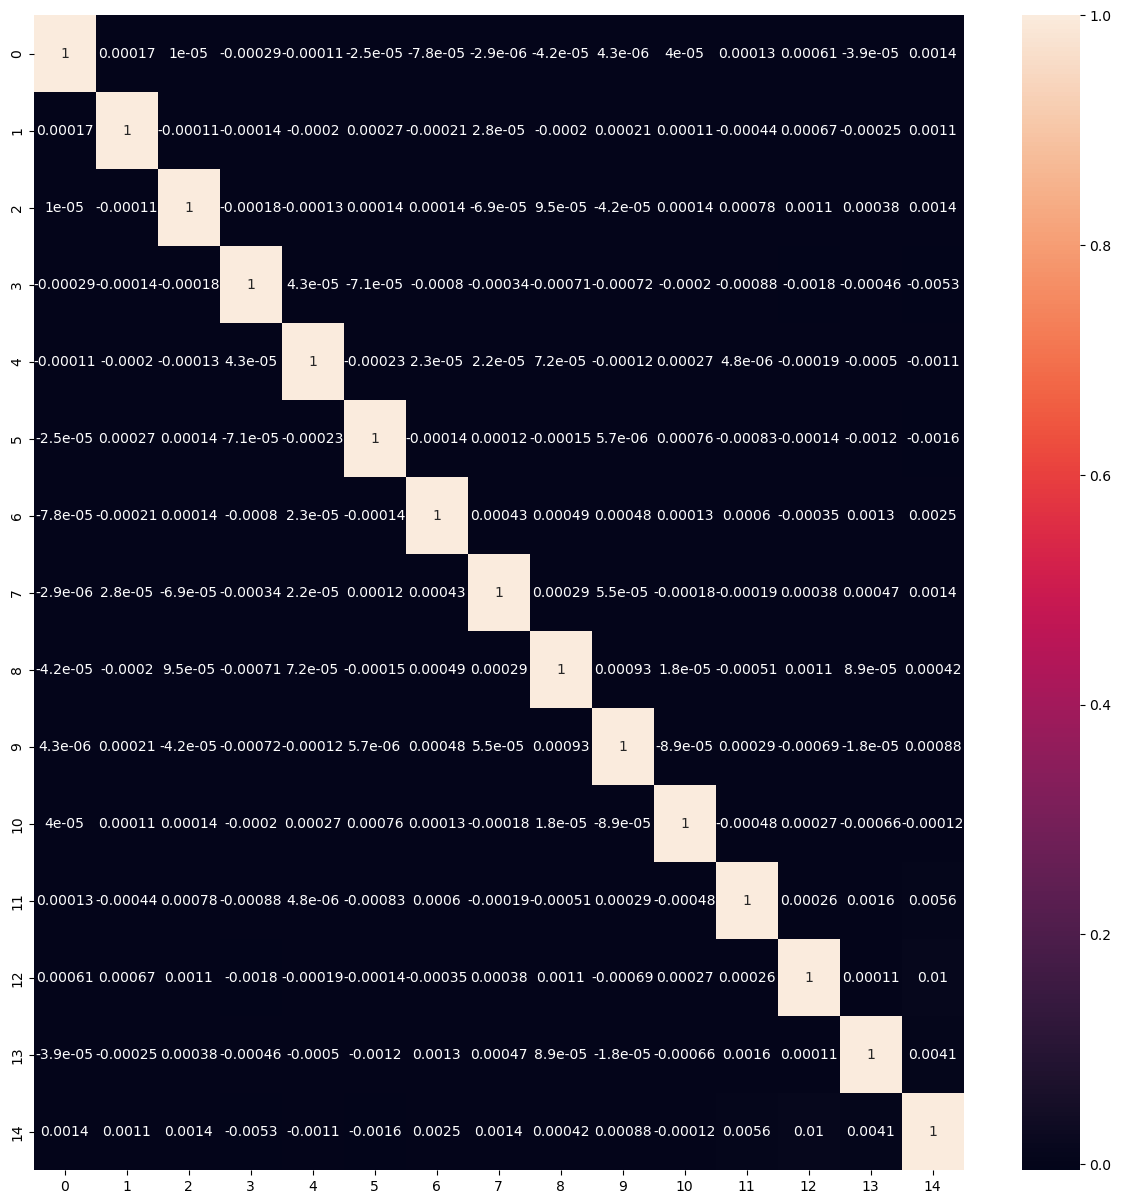

In [50]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

In [51]:
X_validation_pca = pca_final.transform(X_validation)
X_validation_pca.shape

(14000, 15)

#### We can now apply logistic regression on the PCA components
#### Model 3: Logistic Regression + PCA

In [52]:
learner_pca = LogisticRegression()

In [53]:
model_pca = learner_pca.fit(X_train_pca, y_train)

#### Making prediction on the validation data

In [54]:
pred_probs_validation = model_pca.predict_proba(X_validation_pca)

In [55]:
"{:2.2}".format(metrics.roc_auc_score(y_validation, pred_probs_validation[:,1]))

'0.86'

In [56]:
confusion_matrix(y_validation, model_pca.predict(X_validation_pca))

array([[9552, 3071],
       [ 247, 1130]], dtype=int64)

In [57]:
precision_score(y_validation, model_pca.predict(X_validation_pca))

0.26898357533920497

In [58]:
recall_score(y_validation, model_pca.predict(X_validation_pca))

0.8206245461147422

In [59]:
evaluate_model(model_pca, X_train_pca, y_train, X_validation_pca, y_validation)

Train Accuracy : 0.7941246716025794
Train Precision : 0.7756061171204774
Train Recall : 0.8277207228723827
Train Confusion Matrix:
[[38212 12032]
 [ 8656 41588]]
--------------------------------------------------
Test Accuracy : 0.763
Test Precision : 0.26898357533920497
Test Recall : 0.8206245461147422
Test Confusion Matrix:
[[9552 3071]
 [ 247 1130]]


#### In this study our goal is to correctly identify all customers that are likely to churn. It is okay to predict non churn as churn but a churn should not be predicted as non churn. So we need to maximize the recall score. Recall represents the proportion of actual churn cases correctly predicted by the model. It’s essential when minimizing false negatives (i.e., ensuring that actual churners are not missed).

#### Model 4: Extreme Gradient Boosting : Decision Trees

In [60]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [61]:
# Fit the model to our train and target
xgb_cfl.fit(X_train, y_train)  # default 
# Get our predictions
xgb_predictions = xgb_cfl.predict(X_validation)

In [62]:
evaluate_model(xgb_cfl, X_train, y_train, X_validation,y_validation)

Train Accuracy : 0.9803260090757105
Train Precision : 0.9824094988706099
Train Recall : 0.9781665472494229
Train Confusion Matrix:
[[49364   880]
 [ 1097 49147]]
--------------------------------------------------
Test Accuracy : 0.9388571428571428
Test Precision : 0.6969009826152683
Test Recall : 0.6695715323166304
Test Confusion Matrix:
[[12222   401]
 [  455   922]]


In [63]:
# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5

param_comb = 800

random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='recall', n_jobs=-1, cv=5, verbose=3, random_state=42)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


In [ ]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best recall for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)